# Estimating causal effect of text features on usefulness

In [1]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from patsy import dmatrices

## Look at the data

In [2]:
df = pd.read_csv('saved_data/features.csv')

df.head()

,test,Z1,Z2,stars,n_words,useful,useful_discrete,n_fans,n_reviews
0,1,1,1,5,176,0,0,0,3
1,1,1,0,4,940,39,3,330,1224
2,0,0,0,4,131,1,1,113,1864
3,1,0,0,1,18,0,0,0,6
4,1,0,0,5,63,0,0,0,15


In [3]:
# Which are the average values in each treatment group?

for Z1, Z2 in list(itertools.product([0, 1], repeat=2)):
    print('Z1 = ' + str(Z1) + ', Z2 = ' + str(Z2))
    print(df.loc[(df['Z1'] == Z1) & (df['Z2'] == Z2)].mean())
    print()

Z1 = 0, Z2 = 0
test                 0.879599
Z1                   0.000000
Z2                   0.000000
stars                3.776473
n_words            110.948005
useful               1.025738
useful_discrete      0.434272
n_fans              13.048886
n_reviews          146.732769
dtype: float64

Z1 = 0, Z2 = 1
test              NaN
Z1                NaN
Z2                NaN
stars             NaN
n_words           NaN
useful            NaN
useful_discrete   NaN
n_fans            NaN
n_reviews         NaN
dtype: float64

Z1 = 1, Z2 = 0
test                 0.696995
Z1                   1.000000
Z2                   0.000000
stars                3.732888
n_words            409.682805
useful               4.661937
useful_discrete      1.128548
n_fans              52.112688
n_reviews          345.883139
dtype: float64

Z1 = 1, Z2 = 1
test                 0.369898
Z1                   1.000000
Z2                   1.000000
stars                3.784120
n_words             89.798788
usef

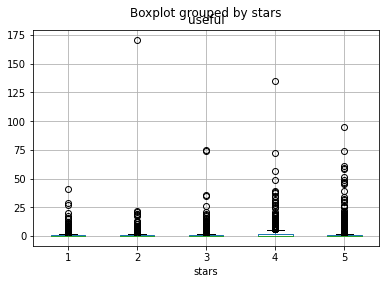

In [4]:
df.boxplot(column='useful', by='stars');

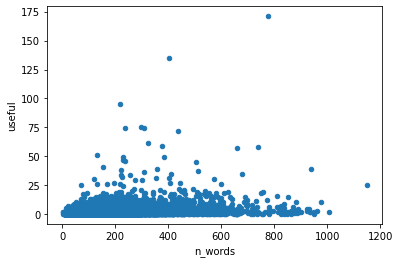

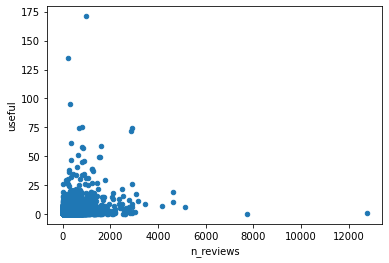

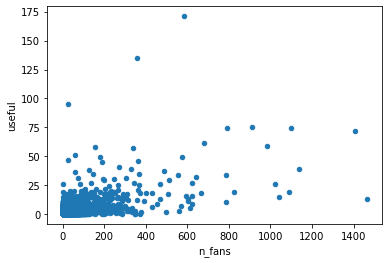

In [5]:
for x in ['n_words', 'n_reviews', 'n_fans']:
    df.plot.scatter(x=x, y='useful')

## Extract treatments, confounders and outcomes

In [6]:
class Data:
    def __init__(self, data, treatments, confounders, include_stars=True):
        self.data = data
        self.treatments = treatments
        self.n_treatments = len(treatments)
        self.treatment_groups = list(itertools.product([0, 1], repeat=self.n_treatments))
        self.confounders = confounders
        self.include_stars = include_stars
        self._get_data()
        self._get_scaled_data()
        
    def _get_scaled_data(self):
        self.X_train_scaled = dict.fromkeys(self.treatment_groups)
        self.X_test_scaled = dict.fromkeys(self.treatment_groups)
        
        confounders_scaled = preprocessing.scale(self.data[self.confounders])
        confounders_scaled = pd.DataFrame(confounders_scaled, index=self.data.index, columns=self.confounders)
        
        treatment_groups = self.data.groupby(self.treatments)
        
        for tg, indexes in treatment_groups.groups.items():
            filter_col = [col for col in self.X_train[tg] if col.startswith('stars')]
            
            self.X_train_scaled[tg] = self.X_train[tg][filter_col].copy()
            self.X_test_scaled[tg] = self.X_test[tg][filter_col].copy()
            
            indexes_train = self.X_train[tg].index
            indexes_test = self.X_test[tg].index
        
            self.X_train_scaled[tg][self.confounders] = confounders_scaled.iloc[indexes_train]
            self.X_test_scaled[tg][self.confounders] = confounders_scaled.iloc[indexes_test]
            
    def _get_data(self):
        self.X_train = dict.fromkeys(self.treatment_groups)
        self.X_test = dict.fromkeys(self.treatment_groups)
        
        self.Y_train = dict.fromkeys(self.treatment_groups)
        self.Y_test = dict.fromkeys(self.treatment_groups)
        
        self.Y_train_discrete = dict.fromkeys(self.treatment_groups)
        self.Y_test_discrete = dict.fromkeys(self.treatment_groups)
        
        treatment_groups = self.data.groupby(self.treatments)
        
        for tg, indexes in treatment_groups.groups.items():
            temp_data_train = self.data.iloc[indexes].loc[self.data['test'] == 0]
            temp_data_test = self.data.iloc[indexes].loc[self.data['test'] == 1]
            
            if self.include_stars:
                self.X_train[tg] = pd.get_dummies(temp_data_train['stars'], drop_first=True, prefix='stars')
                self.X_test[tg] = pd.get_dummies(temp_data_test['stars'], drop_first=True, prefix='stars')
            
            self.X_train[tg][self.confounders] = temp_data_train[self.confounders]
            self.X_test[tg][self.confounders] = temp_data_test[self.confounders]
            
            self.Y_train[tg] = temp_data_train['useful']
            self.Y_test[tg] = temp_data_test['useful']
            
            self.Y_train_discrete[tg] = temp_data_train['useful_discrete']
            self.Y_test_discrete[tg] = temp_data_test['useful_discrete']

In [7]:
treatments = ['Z1', 'Z2']
confounders = ['n_words', 'n_fans', 'n_reviews']

data = Data(df, treatments, confounders)

In [8]:
data.X_train_scaled

{(0,
  0):        stars_2  stars_3  stars_4  stars_5   n_words    n_fans  n_reviews
 2            0        0        1        0 -0.067233  1.648440   4.995672
 28           0        0        0        1  0.386120 -0.194415   0.185469
 50           0        0        0        0  0.078762 -0.279733  -0.469000
 60           0        0        0        1  0.024975 -0.279733  -0.413238
 83           0        0        0        1 -0.005761 -0.245606  -0.298779
 ...        ...      ...      ...      ...       ...       ...        ...
 10082        0        0        1        0  0.117182 -0.279733  -0.398564
 10093        0        0        0        0  0.501380 -0.245606  -0.307584
 10099        0        1        0        0  0.316965 -0.092035  -0.102145
 10114        1        0        0        0  0.209389 -0.228542  -0.187255
 10121        0        0        1        0  0.163286 -0.160288  -0.108015
 
 [697 rows x 7 columns],
 (0, 1): None,
 (1,
  0):        stars_2  stars_3  stars_4  stars_5   n_wor

## Helper functions

In [9]:
# Should we use all data or only the data that we have for each pair of groups?

def calculate_pairwise_ate(models, X):
    for tg1, tg2 in list(itertools.combinations(models.keys(), 2)):
        print('Comparing treatment groups ' + str(tg1) + ' and ' + str(tg2) + '.')
        m_1 = models[tg1]
        m_2 = models[tg2]

        x1 = X[tg1]
        x2 = X[tg2]

        x = pd.concat([x1, x2])

        ate = np.mean(m_1.predict(x) - m_2.predict(x))

        print('The ATE is ' + str(round(ate, 2)) + '.')

## Fit a regression model E[Y|T, X]

In [10]:
def print_lm_info(lm, x_test, y_test):
    preds = lm.predict(x_test)
    
    # The coefficients
    print('Coefficients: \n', lm.coef_)

    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(y_test, preds))

    # The coefficient of determination
    print('R squared: %.2f'
          % r2_score(y_test, preds))

lm_models = {}

for tg in data.treatment_groups:
    print('Treatment group ' + str(tg))
    x = data.X_test[tg]
    y = data.Y_test[tg]
    if x is not None:
        lm = LinearRegression()
        lm.fit(x, y)
        lm_models[tg] = lm
        print_lm_info(lm, data.X_train[tg], data.Y_train[tg])  # Use train data (for sIBP) to evaluate fit
    else:
        print('There is no data available for this treatment grop.')
    print()

# Calculate the average treatment effect between pairwise treatment groups
calculate_pairwise_ate(lm_models, data.X_test)

Treatment group (0, 0)
Coefficients: 
 [-0.33768296 -0.36526822 -0.27858156 -0.13633214  0.00783825  0.03814328
 -0.00159852]
Mean squared error: 8.78
R squared: 0.48

Treatment group (0, 1)
There is no data available for this treatment grop.

Treatment group (1, 0)
Coefficients: 
 [ 1.87701489 -0.18778622  0.63973041  0.67213231  0.0074892   0.0652849
 -0.00446333]
Mean squared error: 62.22
R squared: 0.50

Treatment group (1, 1)
Coefficients: 
 [-0.4394981  -0.75625763 -0.66825657 -0.43463496  0.0059957   0.04953838
 -0.00208061]
Mean squared error: 3.13
R squared: -0.58

Comparing treatment groups (0, 0) and (1, 0).
The ATE is 0.23.
Comparing treatment groups (0, 0) and (1, 1).
The ATE is -0.04.
Comparing treatment groups (1, 0) and (1, 1).
The ATE is -0.03.


## Fit a logistic model Pr[Y|T, X]

In [11]:
clf_models = {}

for tg in data.treatment_groups:
    print('Treatment group ' + str(tg))
    x = data.X_test_scaled[tg]
    y = data.Y_test_discrete[tg]
    if x is not None:
        clf = LogisticRegression(max_iter=200)
        clf.fit(x, y)
        clf_models[tg] = clf
        # TODO: Evaluate fit
    else:
        print('There is no data available for this treatment grop.')
    print()

# Calculate the average treatment effect between pairwise treatment groups
calculate_pairwise_ate(clf_models, data.X_test_scaled)

Treatment group (0, 0)

Treatment group (0, 1)
There is no data available for this treatment grop.

Treatment group (1, 0)

Treatment group (1, 1)

Comparing treatment groups (0, 0) and (1, 0).
The ATE is -0.65.
Comparing treatment groups (0, 0) and (1, 1).
The ATE is -0.01.
Comparing treatment groups (1, 0) and (1, 1).
The ATE is 0.26.


## Fit a ZIP model 

In [13]:
zip_models = {}

for tg in data.treatment_groups:
    print('Treatment group ' + str(tg))
    x = data.X_test_scaled[tg]
    y = data.Y_test[tg]
    if x is not None:
        zip_model = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit(maxiter=200)
        # print(zip_model.summary())
        zip_models[tg] = zip_model
        # TODO: Evaluate fit
    else:
        print('There is no data available for this treatment grop.')
    print()

Treatment group (0, 0)
Optimization terminated successfully.
         Current function value: 1.267820
         Iterations: 65
         Function evaluations: 69
         Gradient evaluations: 69


/Users/antmats/Desktop/causality-and-causal-inference/project/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/antmats/Desktop/causality-and-causal-inference/project/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Treatment group (0, 1)
There is no data available for this treatment grop.

Treatment group (1, 0)
Optimization terminated successfully.
         Current function value: 3.340207
         Iterations: 57
         Function evaluations: 63
         Gradient evaluations: 63

Treatment group (1, 1)
Optimization terminated successfully.
         Current function value: 1.478595
         Iterations: 64
         Function evaluations: 67
         Gradient evaluations: 67



/Users/antmats/Desktop/causality-and-causal-inference/project/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Calculate the average treatment effect between pairwise treatment groups

# calculate_pairwise_ate(zip_models, data.X_test_scaled)

for tg1, tg2 in list(itertools.combinations(zip_models.keys(), 2)):
    print('Comparing treatment groups ' + str(tg1) + ' and ' + str(tg2) + '.')
    m_1 = zip_models[tg1]
    m_2 = zip_models[tg2]

    x1 = data.X_test_scaled[tg1]
    x2 = data.X_test_scaled[tg2]

    x = pd.concat([x1, x2])
    
    ate = np.mean(m_1.predict(x, exog_infl=x) - m_2.predict(x, exog_infl=x))

    print('The ATE is ' + str(round(ate, 2)) + '.')

Comparing treatment groups (0, 0) and (1, 0).
The ATE is 1.29.
Comparing treatment groups (0, 0) and (1, 1).
The ATE is -0.22.
Comparing treatment groups (1, 0) and (1, 1).
The ATE is -18.98.
